In [1]:
import pandas as pd
from pathlib import Path
import json

# load snapshots
base_path = Path('/data/blockchain-interoperability/blockchain-social-media/twitter-data/')
timestamp = pd.to_datetime(pd.read_pickle(base_path / 'snapshots/timestamp_ms.pkl'),unit='ms').astype('datetime64[m]')
text = pd.read_pickle(base_path / 'snapshots/whole_text.pkl')

# load cluster info
cluster_ids = json.load(open(base_path/'kmeans_clusters/kmeans_init_clusters.json'))
index_to_cluster = {
    idx:int(c_id)
    for c_id, idxs in cluster_ids.items() 
    for idx in idxs
}

# load sentiment
sentiment = pd.read_pickle(base_path / 'sentiment/transformer/sentiment.pkl')
sentiment_score = pd.read_pickle(base_path / 'sentiment/transformer/sentiment_score.pkl')

# turn into combined dataframe
df = pd.concat([timestamp, text, sentiment, sentiment_score],axis=1)
df['cluster_id'] = df.index.map(index_to_cluster)

In [2]:
def get_sent_stat(timestamp,subgroup):
    # print(subgroup)
    # print(subgroup.columns)
    neg_count = (subgroup['sentiment'] == -1).sum()
    neu_count = (subgroup['sentiment'] == 0).sum()
    pos_count = (subgroup['sentiment'] == 1).sum()
    (subgroup['sentiment'] + 1) / 2
    return {
        'Timestamp': timestamp,
        'Tweet Count': len(subgroup),
        'Negative Count': neg_count,
        'Neutral Count': neu_count,
        'Positive Count': pos_count,
        'Negative Ratio': neg_count / len(subgroup),
        'Neutral Ratio': neu_count / len(subgroup),
        'Positive Ratio': pos_count / len(subgroup),
        'Average Sentiment': ((subgroup['sentiment'] + 1)/2).mean(), 
        'Negative Average': subgroup[subgroup['sentiment'] == -1]['sentiment_score'].mean(),
        'Neutral Average': subgroup[subgroup['sentiment'] == 0]['sentiment_score'].mean(),
        'Positive Average': subgroup[subgroup['sentiment'] == 1]['sentiment_score'].mean(),
    }

def get_timeseries(df, interval = '30min'):
    per_delta = pd.DataFrame([get_sent_stat(t,s) for t,s in df.resample(interval, on='timestamp_ms') ])
    return per_delta

# df.resample('30min', on='timestamp_ms').agg(get_sent_stat)

In [4]:
range(df['cluster_id'].max())

[0, 1, 2, 3, 4, 5]

In [7]:
ax.get_legend_handles_labels()

([<matplotlib.collections.PolyCollection at 0x7f98ed61f580>,
 ['Negative Ratio', 'Neutral Ratio', 'Positive Ratio'])

In [23]:
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [25]:
sns.color_palette('Dark2')

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

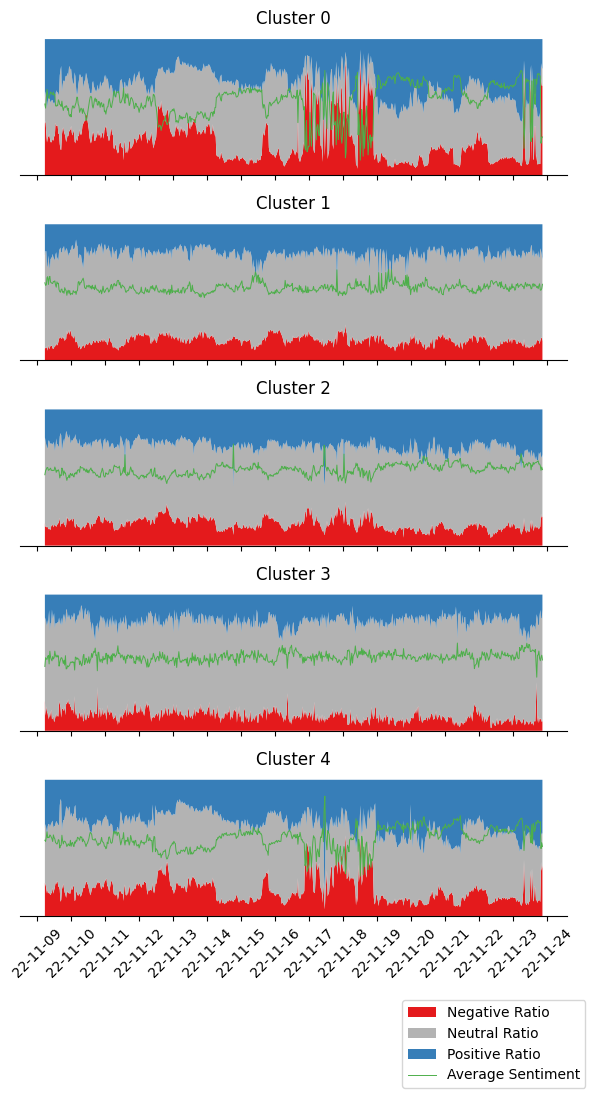

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


pos_color = sns.color_palette('Set1')[1]
neu_color = sns.color_palette('Set2')[-1]
neg_color = sns.color_palette('Set1')[0]
avg_color = sns.color_palette('Set1')[2]


n_clusters = df['cluster_id'].max()
fig,axes = plt.subplots(nrows = n_clusters + 1, figsize= (6,10), sharex = True)

for ax, cluster_id in zip(axes.ravel(), [None]+list(range(n_clusters))): 

    if cluster_id is None: 
        per_delta = get_timeseries(df)
    else:
        per_delta = get_timeseries(df[df['cluster_id'] == cluster_id])

    ax.stackplot(
        per_delta['Timestamp'],
        per_delta['Negative Ratio'],
        per_delta['Neutral Ratio'],
        per_delta['Positive Ratio'],
        labels = ['Negative Ratio', 'Neutral Ratio', 'Positive Ratio'],
        colors = [neg_color,neu_color,pos_color]
    )

    ax.plot(
        per_delta['Timestamp'],
        per_delta['Average Sentiment'],
        linewidth=0.7,
        color=avg_color
    )

    ax.set_title(f'Cluster {cluster_id}')
    # ax.set_xticklabels(per_delta['Timestamp'].dt.strftime('%y-%m-%d'))
    ax.set_yticks([])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    # ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


fig.legend(
    ['Negative Ratio', 'Neutral Ratio', 'Positive Ratio', 'Average Sentiment'],
    loc = 'lower right',
    bbox_to_anchor=(1,-0.1)
)
plt.xticks(rotation=45)
fig.tight_layout()


fig.savefig('../plots/sentiment.')

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def draw_sentiment_timeseries(cluster_idx=None):
    if cluster_idx is not None:
        per_delta = get_timeseries(df[df['cluster_id'] == cluster_idx])
        title = f'Cluster {cluster_idx+1}'
    else:
        per_delta = get_timeseries(df)
        title = 'All Clusters'

    fig = go.Figure(
        data = [
            go.Bar(
                x = per_delta['timestamp'],
                y = per_delta['neg_count'] / per_delta['tweet_count'],
                name = 'Negative Sentiment Ratio',
                marker_color = '#e8776b',
            ),
            go.Bar(
                x = per_delta['timestamp'],
                y = per_delta['neu_count'] / per_delta['tweet_count'],
                name = 'Neutral Sentiment Ratio',
                marker_color = '#e6e6e6',
            ),
            go.Bar(
                x = per_delta['timestamp'],
                y = per_delta['pos_count'] / per_delta['tweet_count'],
                name = 'Positive Sentiment Ratio',
                marker_color = '#6b95e8',
                # yaxis='y2',
            ),
            go.Scatter(
                name = 'Average Sentiment',
                x = per_delta['timestamp'],
                y = per_delta['average'],
                line_color = '#44c767',
            )
        ],
        layout = {
            'barmode':'stack',
            'width': 600,
            'height': 200,
            'showlegend': False,
            'margin': {'l':0,'r':0,'t':0,'b':0},
            'xaxis': {
                'visible': False
            },
            'yaxis': {
                'visible':False
            }
        }
    )
    
    fig.show()
    return fig



all_figs = [
    draw_sentiment_timeseries(i).write_image(f'../plots/sentiment/cluster_{i}.png')
    for i in [None] + list(range(6))
]
